# Ejercicio - Crear un paquete
Creación de entornos virtuales

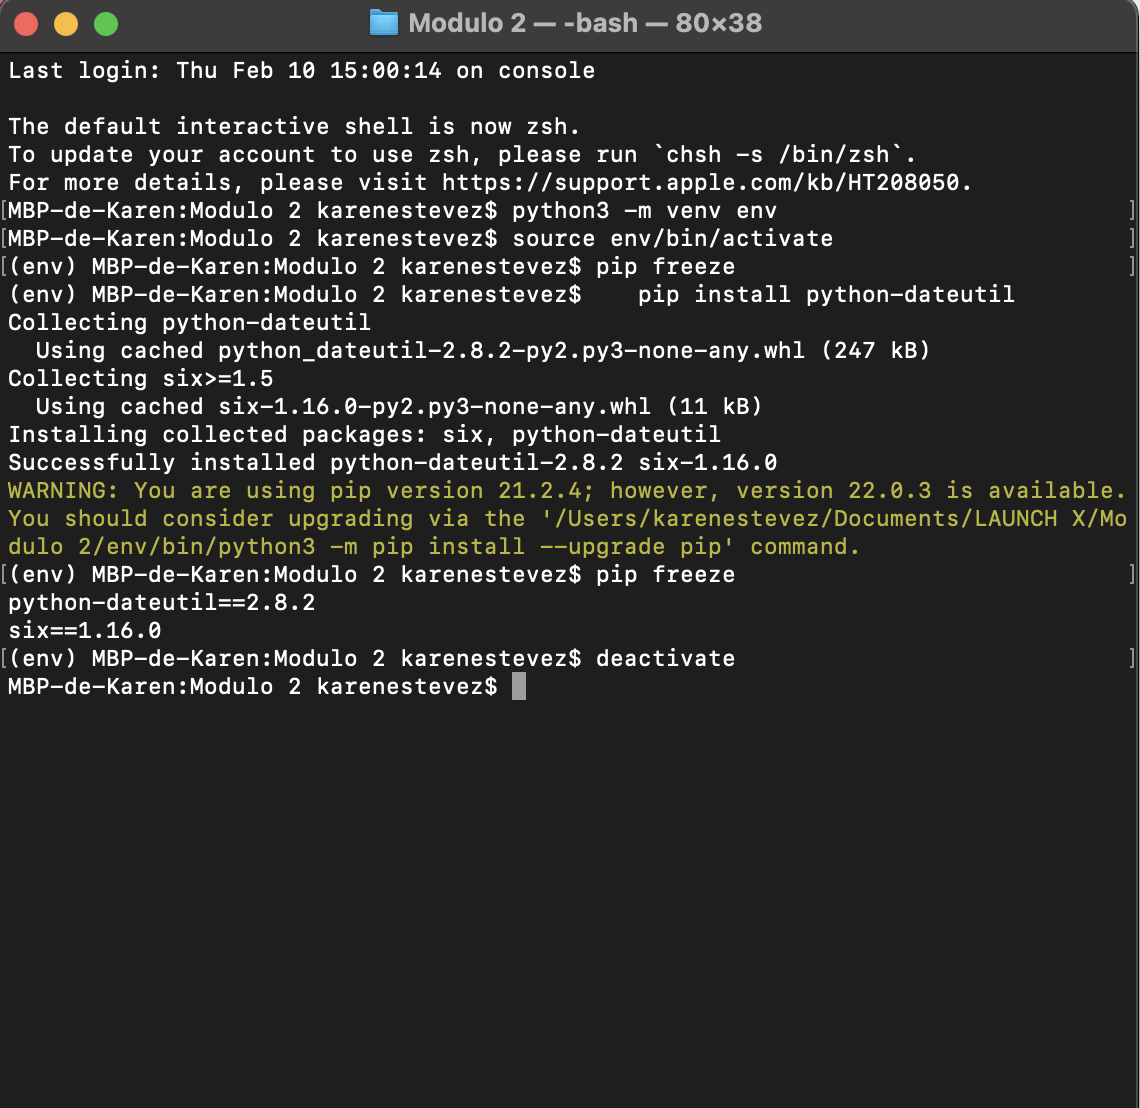

In [7]:
from IPython.display import Image
Image(filename="kata2.png", width=400, height=400)

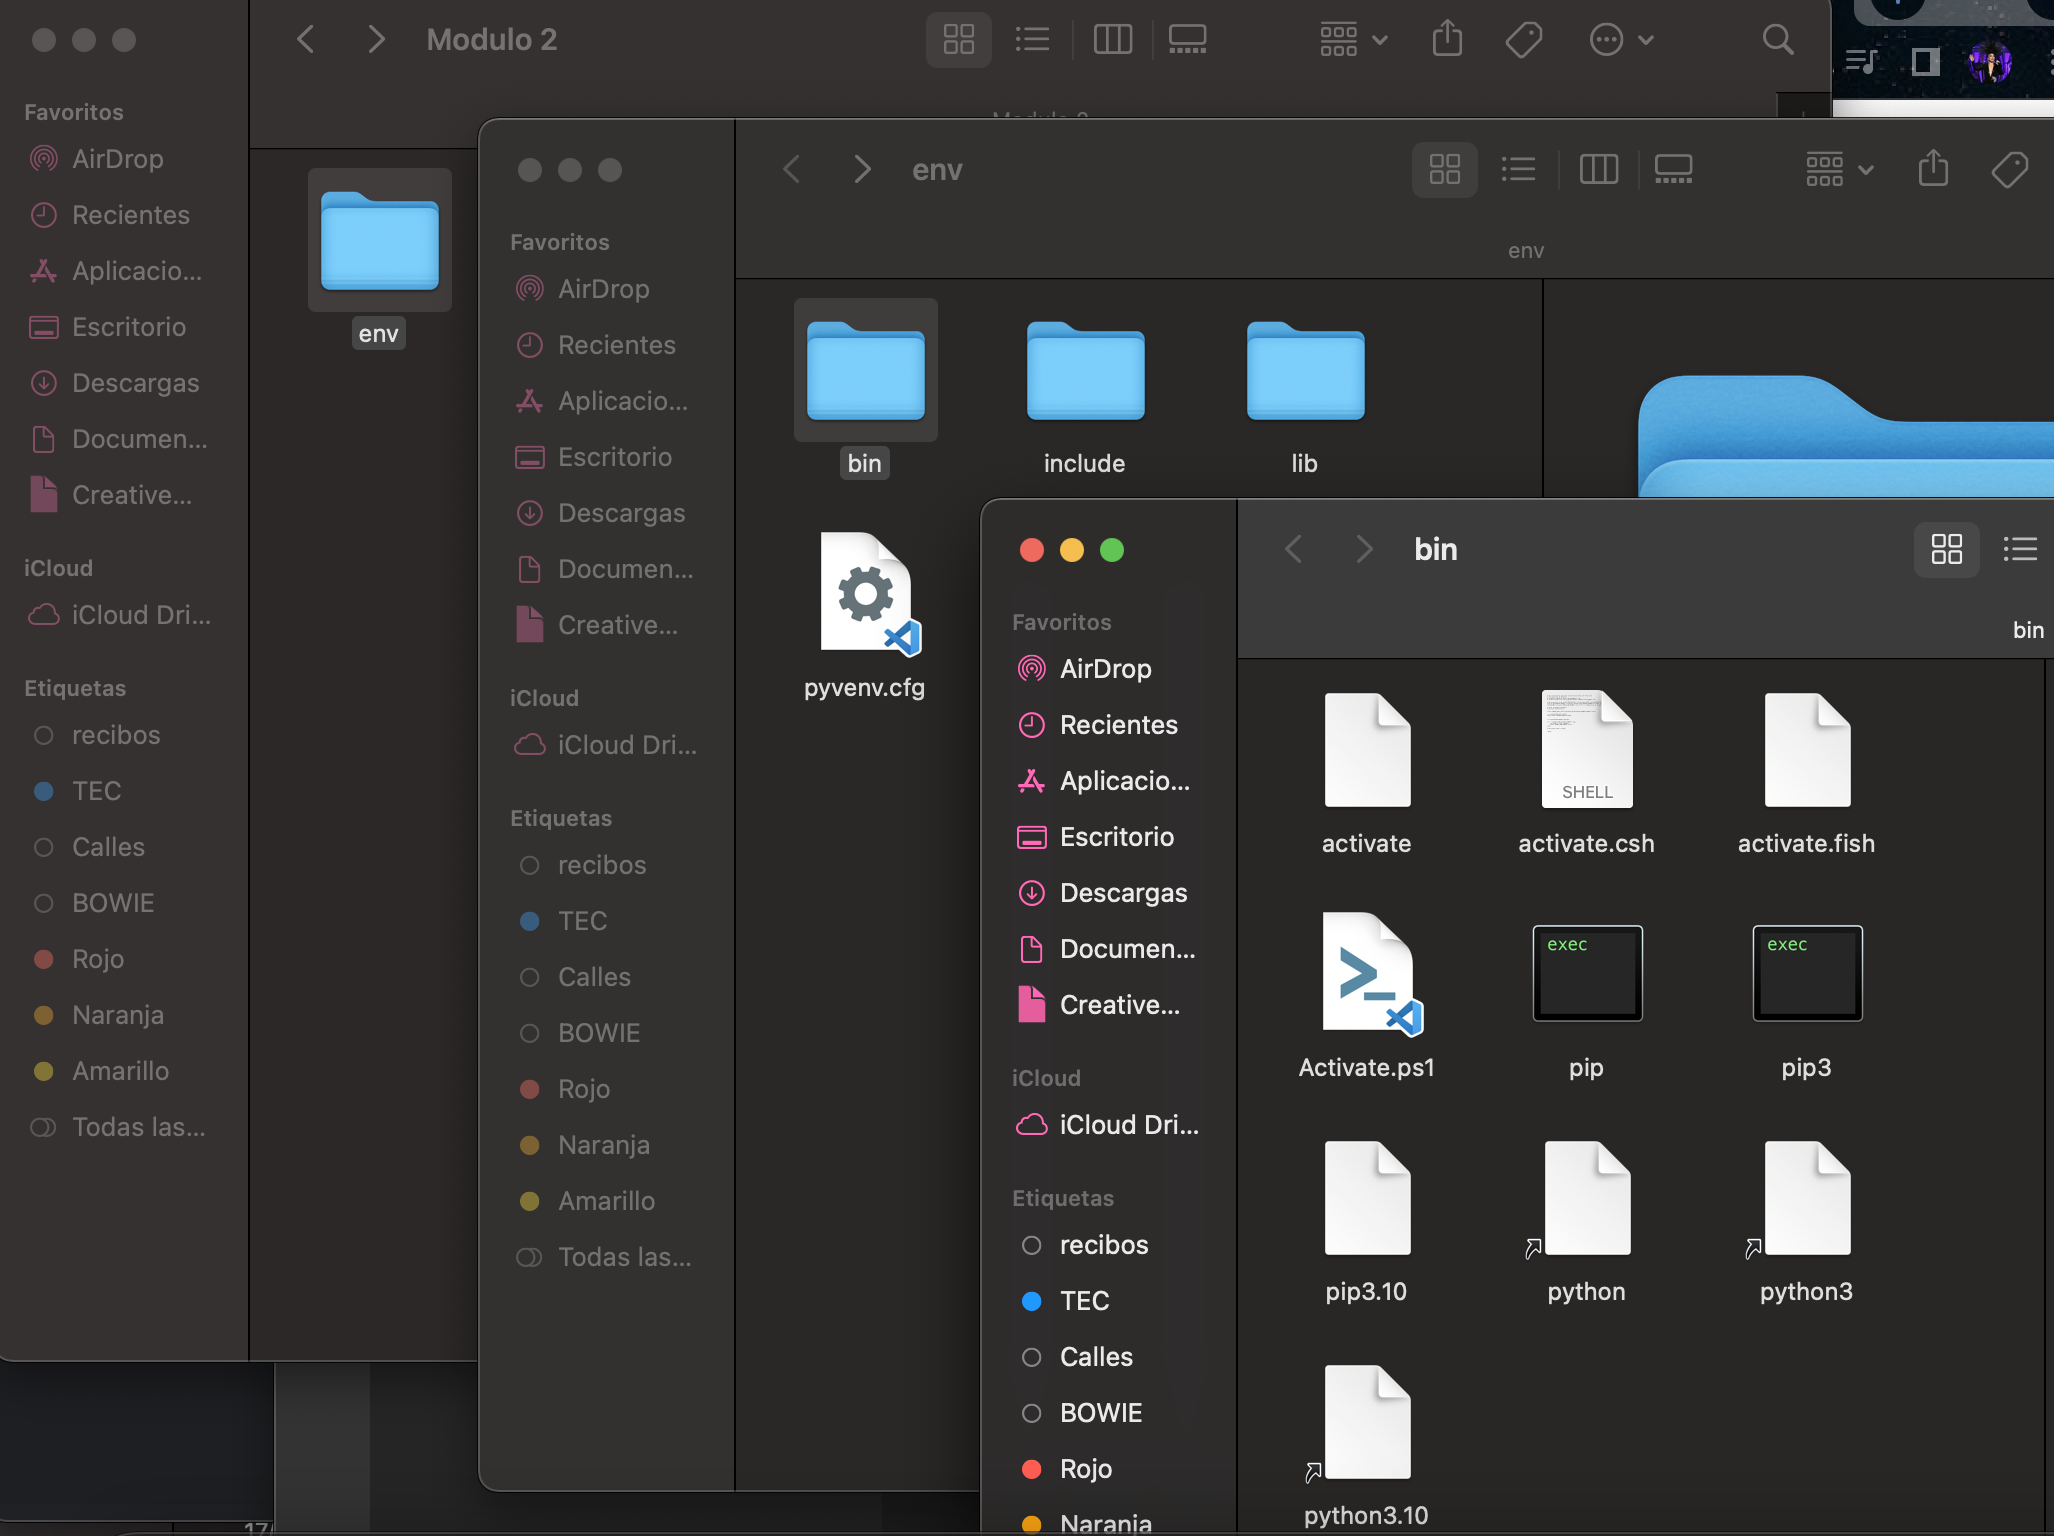

In [4]:
from IPython.display import Image
Image(filename="env paquete.png", width=600, height=400)

# Archivos de instalación
Codigo de archivo pyvenv.cfg

In [ ]:
home = /Library/Frameworks/Python.framework/Versions/3.10/bin
include-system-site-packages = false
version = 3.10.2

Codigo de archivo Activate.ps1

In [ ]:
<#
.Synopsis
Activate a Python virtual environment for the current PowerShell session.

.Description
Pushes the python executable for a virtual environment to the front of the
$Env:PATH environment variable and sets the prompt to signify that you are
in a Python virtual environment. Makes use of the command line switches as
well as the `pyvenv.cfg` file values present in the virtual environment.

.Parameter VenvDir
Path to the directory that contains the virtual environment to activate. The
default value for this is the parent of the directory that the Activate.ps1
script is located within.

.Parameter Prompt
The prompt prefix to display when this virtual environment is activated. By
default, this prompt is the name of the virtual environment folder (VenvDir)
surrounded by parentheses and followed by a single space (ie. '(.venv) ').

.Example
Activate.ps1
Activates the Python virtual environment that contains the Activate.ps1 script.

.Example
Activate.ps1 -Verbose
Activates the Python virtual environment that contains the Activate.ps1 script,
and shows extra information about the activation as it executes.

.Example
Activate.ps1 -VenvDir C:\Users\MyUser\Common\.venv
Activates the Python virtual environment located in the specified location.

.Example
Activate.ps1 -Prompt "MyPython"
Activates the Python virtual environment that contains the Activate.ps1 script,
and prefixes the current prompt with the specified string (surrounded in
parentheses) while the virtual environment is active.

.Notes
On Windows, it may be required to enable this Activate.ps1 script by setting the
execution policy for the user. You can do this by issuing the following PowerShell
command:

PS C:\> Set-ExecutionPolicy -ExecutionPolicy RemoteSigned -Scope CurrentUser

For more information on Execution Policies: 
https://go.microsoft.com/fwlink/?LinkID=135170

#>
Param(
    [Parameter(Mandatory = $false)]
    [String]
    $VenvDir,
    [Parameter(Mandatory = $false)]
    [String]
    $Prompt
)

<# Function declarations --------------------------------------------------- #>

<#
.Synopsis
Remove all shell session elements added by the Activate script, including the
addition of the virtual environment's Python executable from the beginning of
the PATH variable.

.Parameter NonDestructive
If present, do not remove this function from the global namespace for the
session.

#>
function global:deactivate ([switch]$NonDestructive) {
    # Revert to original values

    # The prior prompt:
    if (Test-Path -Path Function:_OLD_VIRTUAL_PROMPT) {
        Copy-Item -Path Function:_OLD_VIRTUAL_PROMPT -Destination Function:prompt
        Remove-Item -Path Function:_OLD_VIRTUAL_PROMPT
    }

    # The prior PYTHONHOME:
    if (Test-Path -Path Env:_OLD_VIRTUAL_PYTHONHOME) {
        Copy-Item -Path Env:_OLD_VIRTUAL_PYTHONHOME -Destination Env:PYTHONHOME
        Remove-Item -Path Env:_OLD_VIRTUAL_PYTHONHOME
    }

    # The prior PATH:
    if (Test-Path -Path Env:_OLD_VIRTUAL_PATH) {
        Copy-Item -Path Env:_OLD_VIRTUAL_PATH -Destination Env:PATH
        Remove-Item -Path Env:_OLD_VIRTUAL_PATH
    }

    # Just remove the VIRTUAL_ENV altogether:
    if (Test-Path -Path Env:VIRTUAL_ENV) {
        Remove-Item -Path env:VIRTUAL_ENV
    }

    # Just remove VIRTUAL_ENV_PROMPT altogether.
    if (Test-Path -Path Env:VIRTUAL_ENV_PROMPT) {
        Remove-Item -Path env:VIRTUAL_ENV_PROMPT
    }

    # Just remove the _PYTHON_VENV_PROMPT_PREFIX altogether:
    if (Get-Variable -Name "_PYTHON_VENV_PROMPT_PREFIX" -ErrorAction SilentlyContinue) {
        Remove-Variable -Name _PYTHON_VENV_PROMPT_PREFIX -Scope Global -Force
    }

    # Leave deactivate function in the global namespace if requested:
    if (-not $NonDestructive) {
        Remove-Item -Path function:deactivate
    }
}

<#
.Description
Get-PyVenvConfig parses the values from the pyvenv.cfg file located in the
given folder, and returns them in a map.

For each line in the pyvenv.cfg file, if that line can be parsed into exactly
two strings separated by `=` (with any amount of whitespace surrounding the =)
then it is considered a `key = value` line. The left hand string is the key,
the right hand is the value.

If the value starts with a `'` or a `"` then the first and last character is
stripped from the value before being captured.

.Parameter ConfigDir
Path to the directory that contains the `pyvenv.cfg` file.
#>
function Get-PyVenvConfig(
    [String]
    $ConfigDir
) {
    Write-Verbose "Given ConfigDir=$ConfigDir, obtain values in pyvenv.cfg"

    # Ensure the file exists, and issue a warning if it doesn't (but still allow the function to continue).
    $pyvenvConfigPath = Join-Path -Resolve -Path $ConfigDir -ChildPath 'pyvenv.cfg' -ErrorAction Continue

    # An empty map will be returned if no config file is found.
    $pyvenvConfig = @{ }

    if ($pyvenvConfigPath) {

        Write-Verbose "File exists, parse `key = value` lines"
        $pyvenvConfigContent = Get-Content -Path $pyvenvConfigPath

        $pyvenvConfigContent | ForEach-Object {
            $keyval = $PSItem -split "\s*=\s*", 2
            if ($keyval[0] -and $keyval[1]) {
                $val = $keyval[1]

                # Remove extraneous quotations around a string value.
                if ("'""".Contains($val.Substring(0, 1))) {
                    $val = $val.Substring(1, $val.Length - 2)
                }

                $pyvenvConfig[$keyval[0]] = $val
                Write-Verbose "Adding Key: '$($keyval[0])'='$val'"
            }
        }
    }
    return $pyvenvConfig
}


<# Begin Activate script --------------------------------------------------- #>

# Determine the containing directory of this script
$VenvExecPath = Split-Path -Parent $MyInvocation.MyCommand.Definition
$VenvExecDir = Get-Item -Path $VenvExecPath

Write-Verbose "Activation script is located in path: '$VenvExecPath'"
Write-Verbose "VenvExecDir Fullname: '$($VenvExecDir.FullName)"
Write-Verbose "VenvExecDir Name: '$($VenvExecDir.Name)"

# Set values required in priority: CmdLine, ConfigFile, Default
# First, get the location of the virtual environment, it might not be
# VenvExecDir if specified on the command line.
if ($VenvDir) {
    Write-Verbose "VenvDir given as parameter, using '$VenvDir' to determine values"
}
else {
    Write-Verbose "VenvDir not given as a parameter, using parent directory name as VenvDir."
    $VenvDir = $VenvExecDir.Parent.FullName.TrimEnd("\\/")
    Write-Verbose "VenvDir=$VenvDir"
}

# Next, read the `pyvenv.cfg` file to determine any required value such
# as `prompt`.
$pyvenvCfg = Get-PyVenvConfig -ConfigDir $VenvDir

# Next, set the prompt from the command line, or the config file, or
# just use the name of the virtual environment folder.
if ($Prompt) {
    Write-Verbose "Prompt specified as argument, using '$Prompt'"
}
else {
    Write-Verbose "Prompt not specified as argument to script, checking pyvenv.cfg value"
    if ($pyvenvCfg -and $pyvenvCfg['prompt']) {
        Write-Verbose "  Setting based on value in pyvenv.cfg='$($pyvenvCfg['prompt'])'"
        $Prompt = $pyvenvCfg['prompt'];
    }
    else {
        Write-Verbose "  Setting prompt based on parent's directory's name. (Is the directory name passed to venv module when creating the virtual environment)"
        Write-Verbose "  Got leaf-name of $VenvDir='$(Split-Path -Path $venvDir -Leaf)'"
        $Prompt = Split-Path -Path $venvDir -Leaf
    }
}

Write-Verbose "Prompt = '$Prompt'"
Write-Verbose "VenvDir='$VenvDir'"

# Deactivate any currently active virtual environment, but leave the
# deactivate function in place.
deactivate -nondestructive

# Now set the environment variable VIRTUAL_ENV, used by many tools to determine
# that there is an activated venv.
$env:VIRTUAL_ENV = $VenvDir

if (-not $Env:VIRTUAL_ENV_DISABLE_PROMPT) {

    Write-Verbose "Setting prompt to '$Prompt'"

    # Set the prompt to include the env name
    # Make sure _OLD_VIRTUAL_PROMPT is global
    function global:_OLD_VIRTUAL_PROMPT { "" }
    Copy-Item -Path function:prompt -Destination function:_OLD_VIRTUAL_PROMPT
    New-Variable -Name _PYTHON_VENV_PROMPT_PREFIX -Description "Python virtual environment prompt prefix" -Scope Global -Option ReadOnly -Visibility Public -Value $Prompt

    function global:prompt {
        Write-Host -NoNewline -ForegroundColor Green "($_PYTHON_VENV_PROMPT_PREFIX) "
        _OLD_VIRTUAL_PROMPT
    }
    $env:VIRTUAL_ENV_PROMPT = $Prompt
}

# Clear PYTHONHOME
if (Test-Path -Path Env:PYTHONHOME) {
    Copy-Item -Path Env:PYTHONHOME -Destination Env:_OLD_VIRTUAL_PYTHONHOME
    Remove-Item -Path Env:PYTHONHOME
}

# Add the venv to the PATH
Copy-Item -Path Env:PATH -Destination Env:_OLD_VIRTUAL_PATH
$Env:PATH = "$VenvExecDir$([System.IO.Path]::PathSeparator)$Env:PATH"
